# Clustering
The target of this notebook is to create the whole users dataframe and clustering users into three groups

In [48]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

#忽略警告
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

from sklearn.cluster import KMeans

## Read in data

In [2]:
portfolio = pd.read_csv('data/portfolio.csv')
profile = pd.read_csv('data/profile.csv')
transcript = pd.read_csv('data/transcript.csv')
user_transactions = pd.read_csv('data/user_transactions.csv')
user_offer_df = pd.read_csv('data/user_offer_df.csv')

## Look at each dataframe

In [3]:
print('The shape of portfolio data:', portfolio.shape)
portfolio.head()

The shape of portfolio data: (10, 9)


,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [4]:
print('The shape of profile data:', profile.shape)
profile.head()

The shape of profile data: (17000, 7)


,age,gender,user_id,income,inform_unknown,became_member_year,member_years
0,58,U,68be06ca386d4c31939f3a4f0e3dd783,65404.99,1,2017,1
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.00,0,2017,1
2,58,U,38fe809add3b4fcf9315a9694bb96ff5,65404.99,1,2018,0
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.00,0,2017,1
4,58,U,a03223e636434f42ac4c3df47e8bac43,65404.99,1,2017,1


In [5]:
print('The shape of transcript data:', transcript.shape)
transcript.head()

The shape of transcript data: (306137, 5)


,event,user_id,time,offer_id,day
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [6]:
print('The shape of user transactions data:', user_transactions.shape)
user_transactions.head()

The shape of user transactions data: (16578, 4)


,user_id,transaction_num,transaction_sum,transaction_mean
0,0009655768c64bdeb2e877511632db8f,8,127.60,15.95
1,00116118485d4dfda04fdbaba9a87b5c,3,4.09,1.36
2,0011e0d4e6b944f998e987f904e8c1e5,5,79.46,15.89
3,0020c2b971eb4e9188eac86d93036a77,8,196.86,24.61
4,0020ccbbb6d84e358d3414a3ff76cffd,12,154.05,12.84


In [7]:
print('The shape of user-offer data:', user_offer_df.shape)
user_offer_df.head()

The shape of user-offer data: (76277, 20)


,index,user_id,offer_id,offer_received_time,offer_viewed_time,offer_completed_time,offer_view,offer_complete,difficulty,duration,offer_type,reward,web,email,mobile,social,complete_time,complete_speed,view_time,view_speed
0,0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,6,132,1,1,5,7,bogo,5,1,1,1,0,132,0.21,6,0.96
1,1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,6,-1,1,0,20,10,discount,5,1,1,0,0,-1,0.00,6,0.97
2,2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,18,-1,1,0,10,7,discount,2,1,1,1,0,-1,0.00,18,0.89
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,12,-1,1,0,10,10,discount,2,1,1,1,1,-1,0.00,12,0.95
4,4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,84,-1,1,0,10,5,bogo,10,1,1,1,1,-1,0.00,84,0.30


In [8]:
profile.duplicated().sum()

0

## Create users dataframe

In [52]:
user_data = profile.merge(user_transactions, how='left', on='user_id')
print('The shape of user data:', user_data.shape)
user_data.head()

The shape of user data: (17000, 10)


,age,gender,user_id,income,inform_unknown,became_member_year,member_years,transaction_num,transaction_sum,transaction_mean
0,58,U,68be06ca386d4c31939f3a4f0e3dd783,65404.99,1,2017,1,9.00,20.40,2.27
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.00,0,2017,1,3.00,77.01,25.67
2,58,U,38fe809add3b4fcf9315a9694bb96ff5,65404.99,1,2018,0,6.00,14.30,2.38
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.00,0,2017,1,7.00,159.27,22.75
4,58,U,a03223e636434f42ac4c3df47e8bac43,65404.99,1,2017,1,3.00,4.65,1.55


In [53]:
user_data.isnull().sum()

age                     0
gender                  0
user_id                 0
income                  0
inform_unknown          0
became_member_year      0
member_years            0
transaction_num       422
transaction_sum       422
transaction_mean      422
dtype: int64

In [54]:
# Fill null with 0
user_data.fillna(0, inplace=True)
user_data.isnull().sum()

age                   0
gender                0
user_id               0
income                0
inform_unknown        0
became_member_year    0
member_years          0
transaction_num       0
transaction_sum       0
transaction_mean      0
dtype: int64

In [55]:
# Create features for each type of offer received by each user
user_data['offer_received_num'] = 0
user_data['offer_viewed_num'] = 0
user_data['offer_view_rate'] = 0
user_data['offer_view_speed'] = 0
user_data['offer_completed_num'] = 0
user_data['offer_complete_rate'] = 0
user_data['offer_complete_speed'] = 0

user_data['bogo_received_num'] = 0
user_data['bogo_receive_rate'] = 0
user_data['bogo_viewed_num'] = 0
user_data['bogo_view_rate'] = 0
user_data['bogo_view_speed'] = 0
user_data['bogo_completed_num'] = 0
user_data['bogo_complete_rate'] = 0
user_data['bogo_complete_speed'] = 0

user_data['discount_received_num'] = 0
user_data['discount_receive_rate'] = 0
user_data['discount_viewed_num'] = 0
user_data['discount_view_rate'] = 0
user_data['discount_view_speed'] = 0
user_data['discount_completed_num'] = 0
user_data['discount_complete_rate'] = 0
user_data['discount_complete_speed'] = 0

user_data['info_received_num'] = 0
user_data['info_receive_rate'] = 0
user_data['info_viewed_num'] = 0
user_data['info_view_rate'] = 0
user_data['info_view_speed'] = 0

for i in tqdm(range(user_data.shape[0]), position=0, leave=True):
    user_id = user_data.loc[i]['user_id']
    user_i_df = user_offer_df[user_offer_df['user_id']==user_id]
    
    user_data.loc[i, 'offer_received_num'] = user_i_df.shape[0]
    user_data.loc[i, 'offer_viewed_num'] = user_i_df['offer_view'].sum()
    user_data.loc[i, 'offer_view_rate'] = user_data.loc[i]['offer_viewed_num'] / user_data.loc[i]['offer_received_num']
    user_data.loc[i, 'offer_view_speed'] = user_i_df['view_speed'].mean()
    user_data.loc[i, 'offer_completed_num'] = user_i_df['offer_complete'].sum()
    user_data.loc[i, 'offer_complete_rate'] = user_data.loc[i]['offer_completed_num'] / user_data.loc[i]['offer_received_num']
    user_data.loc[i, 'offer_complete_speed'] = user_i_df['complete_speed'].mean()
    
    user_data.loc[i, 'bogo_received_num'] = user_i_df[user_i_df['offer_type']=='bogo'].shape[0]
    user_data.loc[i, 'bogo_receive_rate'] = user_data.loc[i]['bogo_received_num'] / user_data.loc[i]['offer_received_num']
    user_data.loc[i, 'bogo_viewed_num'] = user_i_df.loc[user_i_df['offer_type']=='bogo']['offer_view'].sum()
    if user_data.loc[i]['offer_viewed_num'] != 0:
        user_data.loc[i, 'bogo_view_rate'] = user_data.loc[i]['bogo_viewed_num'] / user_data.loc[i]['offer_viewed_num']
    user_data.loc[i, 'bogo_view_speed'] = user_i_df.loc[user_i_df['offer_type']=='bogo']['view_speed'].mean()
    user_data.loc[i, 'bogo_completed_num'] = user_i_df.loc[user_i_df['offer_type']=='bogo']['offer_complete'].sum()
    if user_data.loc[i]['offer_completed_num'] != 0:
        user_data.loc[i, 'bogo_complete_rate'] = user_data.loc[i]['bogo_completed_num'] / user_data.loc[i]['offer_completed_num']
    user_data.loc[i, 'bogo_complete_speed'] = user_i_df.loc[user_i_df['offer_type']=='bogo']['complete_speed'].mean()
    
    user_data.loc[i, 'discount_received_num'] = user_i_df[user_i_df['offer_type']=='discount'].shape[0]
    user_data.loc[i, 'discount_receive_rate'] = user_data.loc[i]['discount_received_num'] / user_data.loc[i]['offer_received_num']
    user_data.loc[i, 'discount_viewed_num'] = user_i_df.loc[user_i_df['offer_type']=='discount']['offer_view'].sum()
    if user_data.loc[i]['offer_viewed_num'] != 0:
        user_data.loc[i, 'discount_view_rate'] = user_data.loc[i]['discount_viewed_num'] / user_data.loc[i]['offer_viewed_num']
    user_data.loc[i, 'discount_view_speed'] = user_i_df.loc[user_i_df['offer_type']=='discount']['view_speed'].mean()
    user_data.loc[i, 'discount_completed_num'] = user_i_df.loc[user_i_df['offer_type']=='discount']['offer_complete'].sum()
    if user_data.loc[i]['offer_completed_num'] != 0:
        user_data.loc[i, 'discount_complete_rate'] = user_data.loc[i]['discount_completed_num'] / user_data.loc[i]['offer_completed_num']
    user_data.loc[i, 'discount_complete_speed'] = user_i_df.loc[user_i_df['offer_type']=='discount']['complete_speed'].mean()
    
    user_data.loc[i, 'info_received_num'] = user_i_df[user_i_df['offer_type']=='informational'].shape[0]
    user_data.loc[i, 'info_receive_rate'] = user_data.loc[i]['info_received_num'] / user_data.loc[i]['offer_received_num']
    user_data.loc[i, 'info_viewed_num'] = user_i_df.loc[user_i_df['offer_type']=='informational']['offer_view'].sum()
    if user_data.loc[i]['offer_viewed_num'] != 0:
        user_data.loc[i, 'info_view_rate'] = user_data.loc[i]['info_viewed_num'] / user_data.loc[i]['offer_viewed_num']
    user_data.loc[i, 'info_view_speed'] = user_i_df.loc[user_i_df['offer_type']=='informational']['view_speed'].mean()
    
user_data.head()

  5%|████                                                                          | 872/17000 [01:24<21:46, 12.35it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in longlong_scalars
100%|████████████████████████████████████████████████████████████████████████████| 17000/17000 [25:23<00:00, 11.63it/s]


,age,gender,user_id,income,inform_unknown,became_member_year,member_years,transaction_num,transaction_sum,transaction_mean,...,discount_view_rate,discount_view_speed,discount_completed_num,discount_complete_rate,discount_complete_speed,info_received_num,info_receive_rate,info_viewed_num,info_view_rate,info_view_speed
0,58,U,68be06ca386d4c31939f3a4f0e3dd783,65404.99,1,2017,1,9.00,20.40,2.27,...,1.00,0.58,2,1.00,0.22,0,0.00,0,0.00,nan
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.00,0,2017,1,3.00,77.01,25.67,...,0.00,nan,0,0.00,nan,1,0.50,0,0.00,0.00
2,58,U,38fe809add3b4fcf9315a9694bb96ff5,65404.99,1,2018,0,6.00,14.30,2.38,...,0.00,nan,0,0.00,nan,1,0.50,1,1.00,-0.25
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.00,0,2017,1,7.00,159.27,22.75,...,0.00,nan,0,0.00,nan,1,0.25,1,0.33,0.33
4,58,U,a03223e636434f42ac4c3df47e8bac43,65404.99,1,2017,1,3.00,4.65,1.55,...,1.00,0.76,0,0.00,0.00,2,0.40,0,0.00,0.00


In [57]:
user_data.isnull().sum()

age                           0
gender                        0
user_id                       0
income                        0
inform_unknown                0
became_member_year            0
member_years                  0
transaction_num               0
transaction_sum               0
transaction_mean              0
offer_received_num            0
offer_viewed_num              0
offer_view_rate               6
offer_view_speed              6
offer_completed_num           0
offer_complete_rate           6
offer_complete_speed          6
bogo_received_num             0
bogo_receive_rate             6
bogo_viewed_num               0
bogo_view_rate                0
bogo_view_speed            2008
bogo_completed_num            0
bogo_complete_rate            0
bogo_complete_speed        2008
discount_received_num         0
discount_receive_rate         6
discount_viewed_num           0
discount_view_rate            0
discount_view_speed        2055
discount_completed_num        0
discount

In [58]:
# Fill null with 0
user_data.fillna(0, inplace=True)

In [59]:
# Save users dataframe
user_data.to_csv('data/user_data.csv', index=False)

In [60]:
user_data.drop('became_member_year', axis=1, inplace=True)

def gender_encoder(x):
    """
    Transform gender feature into numeric data.
    
    INPUT:
        x - a string that descibes the gender of each user.
        
    OUTPUT:
        0 - "U".
        1 - "F".
        2 - "M".
        3 - "O".
    """
    
    if x == 'U':
        return 0
    elif x == 'F':
        return 1
    elif x == 'M':
        return 2
    else:
        return 3
user_data['gender'] = user_data['gender'].apply(gender_encoder)
user_data.head()

,age,gender,user_id,income,inform_unknown,member_years,transaction_num,transaction_sum,transaction_mean,offer_received_num,...,discount_view_rate,discount_view_speed,discount_completed_num,discount_complete_rate,discount_complete_speed,info_received_num,info_receive_rate,info_viewed_num,info_view_rate,info_view_speed
0,58,0,68be06ca386d4c31939f3a4f0e3dd783,65404.99,1,1,9.00,20.40,2.27,5,...,1.00,0.58,2,1.00,0.22,0,0.00,0,0.00,0.00
1,55,1,0610b486422d4921ae7d2bf64640c50b,112000.00,0,1,3.00,77.01,25.67,2,...,0.00,0.00,0,0.00,0.00,1,0.50,0,0.00,0.00
2,58,0,38fe809add3b4fcf9315a9694bb96ff5,65404.99,1,0,6.00,14.30,2.38,2,...,0.00,0.00,0,0.00,0.00,1,0.50,1,1.00,-0.25
3,75,1,78afa995795e4d85b5d9ceeca43f5fef,100000.00,0,1,7.00,159.27,22.75,4,...,0.00,0.00,0,0.00,0.00,1,0.25,1,0.33,0.33
4,58,0,a03223e636434f42ac4c3df47e8bac43,65404.99,1,1,3.00,4.65,1.55,5,...,1.00,0.76,0,0.00,0.00,2,0.40,0,0.00,0.00


## Standardization

In [61]:
cluster_data = user_data.drop('user_id', axis=1)
cluster_data = (cluster_data - cluster_data.min()) / cluster_data.std()
cluster_data.head()

,age,gender,income,inform_unknown,member_years,transaction_num,transaction_sum,transaction_mean,offer_received_num,offer_viewed_num,...,discount_view_rate,discount_view_speed,discount_completed_num,discount_complete_rate,discount_complete_speed,info_received_num,info_receive_rate,info_viewed_num,info_view_rate,info_view_speed
0,2.46,0.00,1.76,2.99,0.85,1.76,0.16,0.14,4.65,3.13,...,3.07,5.26,1.82,2.52,5.83,0.00,0.00,0.00,0.00,13.57
1,2.27,1.39,4.07,0.00,0.85,0.59,0.61,1.60,1.86,0.00,...,0.00,3.68,0.00,0.00,5.17,1.14,2.55,0.00,0.00,13.57
2,2.46,0.00,1.76,2.99,0.00,1.17,0.11,0.15,1.86,0.78,...,0.00,3.68,0.00,0.00,5.17,1.14,2.55,1.33,3.78,12.98
3,3.50,1.39,3.47,0.00,0.85,1.37,1.26,1.42,3.72,2.35,...,0.00,3.68,0.00,0.00,5.17,1.14,1.27,1.33,1.26,14.36
4,2.46,0.00,1.76,2.99,0.85,0.59,0.04,0.10,4.65,2.35,...,3.07,5.74,0.00,0.00,5.17,2.29,2.04,0.00,0.00,13.57


## Clustering
Use KMeans method to divide users into three groups

In [67]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(cluster_data)
score = abs(kmeans.score(cluster_data))
print('SSE:', score)

SSE: 475031.04943608947


In [69]:
user_data['cluster'] = kmeans.predict(cluster_data)
user_data.head()

,age,gender,user_id,income,inform_unknown,member_years,transaction_num,transaction_sum,transaction_mean,offer_received_num,...,discount_view_speed,discount_completed_num,discount_complete_rate,discount_complete_speed,info_received_num,info_receive_rate,info_viewed_num,info_view_rate,info_view_speed,cluster
0,58,0,68be06ca386d4c31939f3a4f0e3dd783,65404.99,1,1,9.00,20.40,2.27,5,...,0.58,2,1.00,0.22,0,0.00,0,0.00,0.00,1
1,55,1,0610b486422d4921ae7d2bf64640c50b,112000.00,0,1,3.00,77.01,25.67,2,...,0.00,0,0.00,0.00,1,0.50,0,0.00,0.00,0
2,58,0,38fe809add3b4fcf9315a9694bb96ff5,65404.99,1,0,6.00,14.30,2.38,2,...,0.00,0,0.00,0.00,1,0.50,1,1.00,-0.25,0
3,75,1,78afa995795e4d85b5d9ceeca43f5fef,100000.00,0,1,7.00,159.27,22.75,4,...,0.00,0,0.00,0.00,1,0.25,1,0.33,0.33,2
4,58,0,a03223e636434f42ac4c3df47e8bac43,65404.99,1,1,3.00,4.65,1.55,5,...,0.76,0,0.00,0.00,2,0.40,0,0.00,0.00,0


In [71]:
user_data['cluster'].value_counts(normalize=True)

0   0.38
1   0.31
2   0.31
Name: cluster, dtype: float64

## Results Visualization

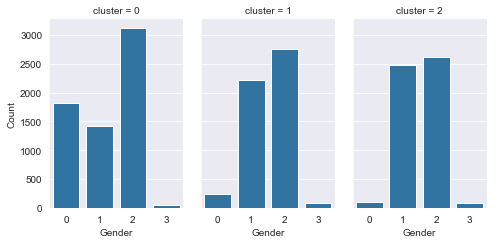

In [88]:
g = sns.FacetGrid(user_data, col="cluster", height=3.5, aspect=.65)
g.map(sns.countplot, "gender")
g.set_axis_labels("Gender", "Count")

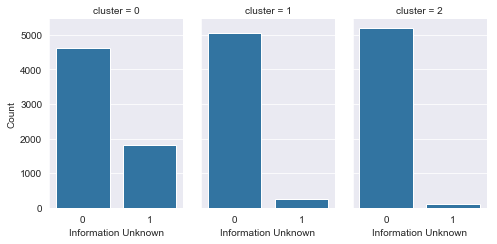

In [89]:
g = sns.FacetGrid(user_data, col="cluster", height=3.5, aspect=.65)
g.map(sns.countplot, "inform_unknown")
g.set_axis_labels("Information Unknown", "Count")

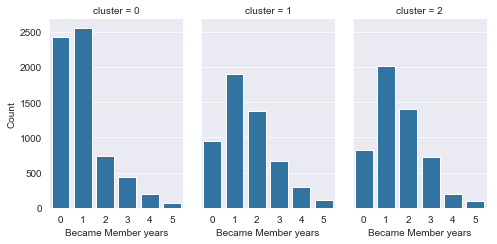

In [90]:
g = sns.FacetGrid(user_data, col="cluster", height=3.5, aspect=.65)
g.map(sns.countplot, "member_years")
g.set_axis_labels("Became Member years", "Count")

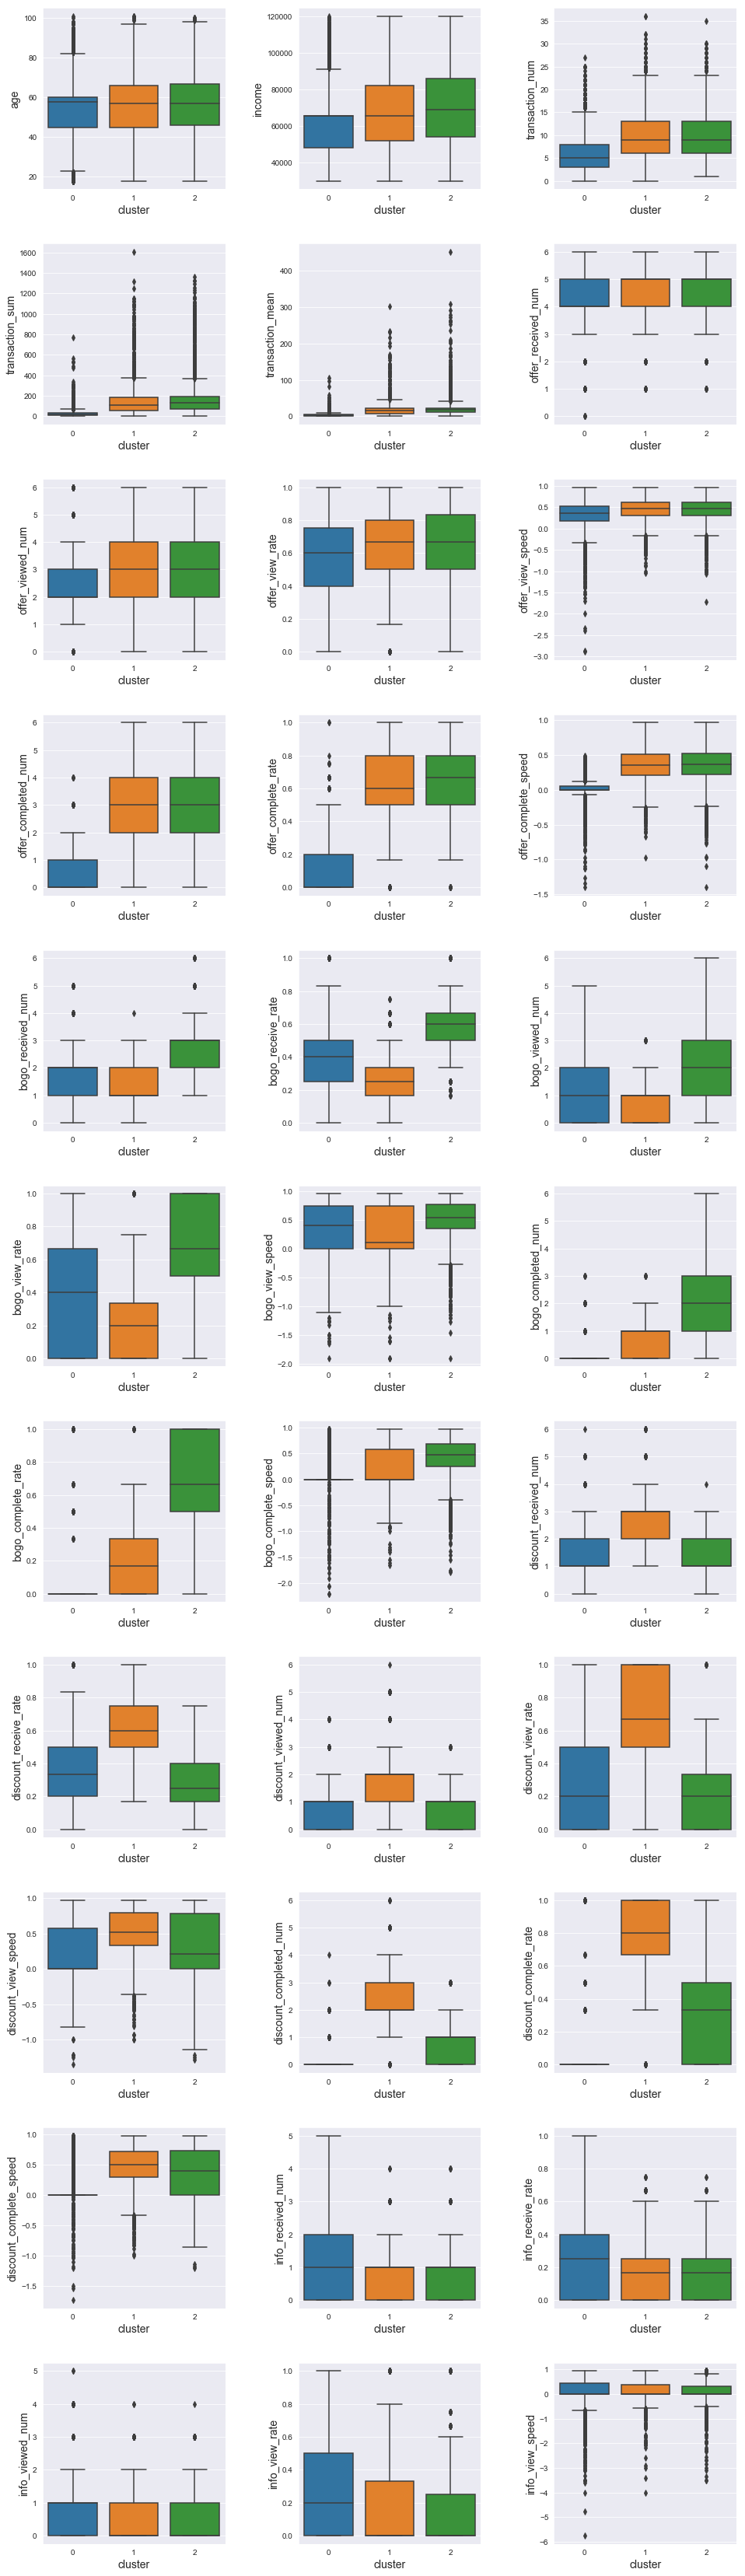

In [114]:
features = user_data.drop(['gender', 'user_id', 'inform_unknown', 'member_years', 'cluster'], axis=1).columns
plt.figure(figsize=(16, 60))
plt.subplots_adjust(hspace=0.3, wspace=0.4)
for i, feature in enumerate(features):
    plt.subplot(11, 3, i+1)
    sns.boxplot(x='cluster', y=feature, data=user_data)
    plt.xlabel('cluster', fontsize=14)
    plt.ylabel(feature, fontsize=14)